### построим сигмоиду

In [1]:
# импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# настраиваем визуализацию
sns.set(rc={'figure.figsize': (9, 6)})

In [3]:
# подбираем x и y
x = np.linspace(-5, 5, 100)
y = 1 / (1 + np.exp(-x))

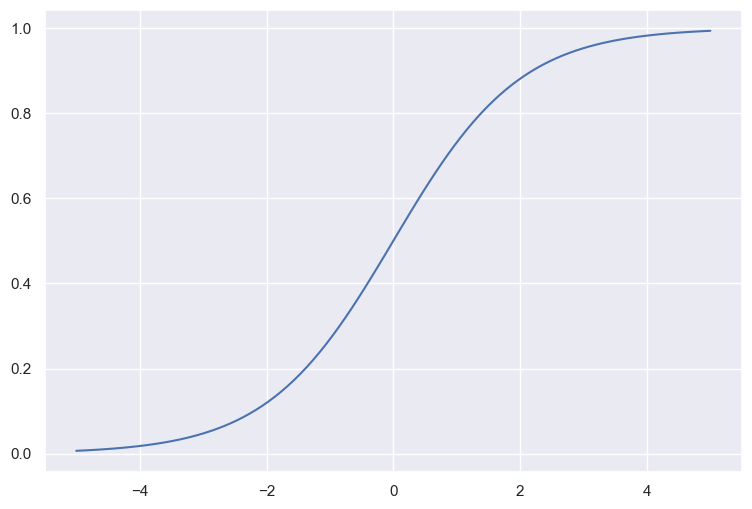

In [4]:
# визуализируем данные
plt.plot(x, y);

In [5]:
# импортируем датасет Титаник
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [7]:
# рассмотрим долю пропущенных значений
df.isna().sum() / df.shape[0]

survived       0.000000
pclass         0.000000
sex            0.000000
age            0.198653
sibsp          0.000000
parch          0.000000
fare           0.000000
embarked       0.002245
class          0.000000
who            0.000000
adult_male     0.000000
deck           0.772166
embark_town    0.002245
alive          0.000000
alone          0.000000
dtype: float64

In [8]:
# удалим лишние столбцы (особенно имеющие много пропусков)
df.drop(columns=['alive', 'deck'], inplace=True)

In [9]:
# заполним пропуски модой
df = df.fillna(value=df.mode().iloc[0])

In [10]:
# cделаем One-Hot преобразование при помощи pandas
df_label = pd.get_dummies(df, drop_first=True)

In [11]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,Southampton,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,Southampton,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,Southampton,True


In [12]:
# разобъём данные на тренировочные и тестовые
# для логистической регрессии stratify=y
from sklearn.model_selection import train_test_split

X = df_label.drop('survived', axis=1)
y = df_label.survived

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

In [13]:
# стандартизируем данные после разбиения
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [14]:
# обучим модель логистической регрессии
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train_std, y_train)

LogisticRegression()

In [15]:
# рассмотрим влияние признаков логистической регрессии на целевую переменную
coef = pd.DataFrame(data=clf.coef_, columns=X.columns)
coef = coef.T
coef.columns = ['coefficient']
coef

,coefficient
pclass,-0.529999
age,-0.253000
sibsp,-0.575095
parch,-0.268571
fare,0.121139
adult_male,-0.685519
alone,-0.252337
sex_male,-0.109862
embarked_Q,0.029436
embarked_S,-0.072038


Если пассажир был взрослым мужчиной, то это уменьшает логарифм шанса выживания на борту на 0.685

Как объяснялось в теории перед заданием, train и test данные не должны подгоняться друг под друга, поэтому используются разные методы, чтобы при трансформации получить разные средние значения и стандартные отклонения. Вы можете убедиться в этом, пропишите print(np.mean(X_train_std), np.std(X_train_std)) и print(np.mean(X_test_std), np.std(X_test_std)) и сравните значения при использовании fit_transform() и обычного transform(). Разница в среднем значении и стандартном отклонении будет выше при использовании разных методов. Таким образом, test данные будут неожиданными для модели. То есть, главное отличие - получаемые после трансформации разные средние значения и стандартные отклонения.

In [16]:
# проследим влияние весов на вероятность выжить
example_data = X_test_std[0].copy()
X_test.head(1)

,pclass,age,sibsp,parch,fare,adult_male,alone,sex_male,embarked_Q,embarked_S,class_Second,class_Third,who_man,who_woman,embark_town_Queenstown,embark_town_Southampton
565,3,24.0,2,0,24.15,True,False,1,0,1,0,1,1,0,0,1


In [17]:
# Подсчитаем вероятность выжить пассажира 566
z = clf.intercept_ + sum(clf.coef_[0] * example_data)
'''
clf.coef_[0] = array([-0.52999883, -0.25299973, -0.57509523, -0.26857069,  0.121139  ,
       -0.6855186 , -0.25233662, -0.10986234,  0.02943551, -0.07203831,
       -0.1466671 , -0.38352623, -0.6855186 , -0.01375934,  0.02943551,
       -0.07203831])
'''
risk = 1 / (1 + np.exp(-z[0]))
print(f'Вероятность выжить равна {risk:.4f}')

Вероятность выжить равна 0.0474


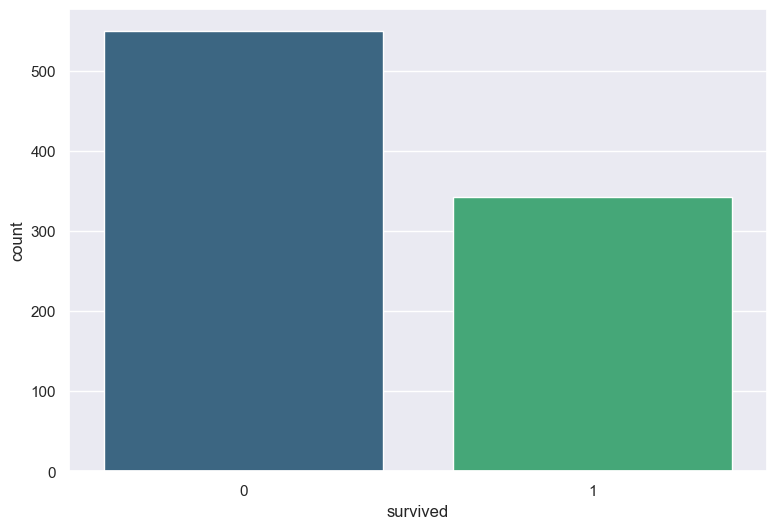

In [18]:
# визуализируем классы
sns.countplot(data=df_label, x='survived', palette='viridis');

# [seaborn.countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html)

In [19]:
# рассмотрим метрику Accuracy:
from sklearn.metrics import accuracy_score

y_pred_test = clf.predict(X_test_std)
y_pred_train = clf.predict(X_train_std)

print(f'Accuracy Train: {accuracy_score(y_train, y_pred_train):.4f}')
print(f'Accuracy Test: {accuracy_score(y_test, y_pred_test):.4f}')

Accuracy Train: 0.8258
Accuracy Test: 0.8380


# [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

**Обязательно**, как и для регрессии, всегда необходимо оценивать метрики как на train, так и на test, чтобы избежать той ситуации, когда наш алгоритм либо сильно подогнал ответы под train выборку, либо наоборот, ему не хватило "сил", чтобы качественно обучиться.

Значение метрики варьируется от нуля до единицы, чем значение ближе к 1, тем лучше алгоритм. 

In [20]:
# рассмотрим метрики precision (точность) и recall (полнота)
from sklearn.metrics import precision_score, recall_score

print(f'Precision Train: {precision_score(y_train, y_pred_train):.4f}')
print(f'Precision Test: {precision_score(y_test, y_pred_test):.4f}')
print()
print(f'Recall Train: {recall_score(y_train, y_pred_train):.4f}')
print(f'Recall Test: {recall_score(y_test, y_pred_test):.4f}')

Precision Train: 0.7922
Precision Test: 0.8125

Recall Train: 0.7399
Recall Test: 0.7536


Значение метрики варьируется от нуля до единицы, чем значение ближе к 1, тем лучше алгоритм. 

In [21]:
# рассмотрим метрику f1 (среднее гармоническое)
from sklearn.metrics import f1_score

print(f'F1 train: {f1_score(y_train, y_pred_train):.4f}')
print(f'F1 test: {f1_score(y_test, y_pred_test):.4f}')

F1 train: 0.7652
F1 test: 0.7820


In [22]:
# рассмотрим метрику ROC-AUC (площадь под кривой ошибок)
from sklearn.metrics import roc_auc_score

y_pred_test_score = clf.predict_proba(X_test_std)
y_pred_train_score = clf.predict_proba(X_train_std)

print(f'ROC-AUC Train: {roc_auc_score(y_train, y_pred_train_score[:,1]):.4f}')
print(f'ROC-AUC Test: {roc_auc_score(y_test, y_pred_test_score[:,1]):.4f}')

ROC-AUC Train: 0.8691
ROC-AUC Test: 0.8683


# [clf.predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba)

# Задача по диабету в Индии

**Контекст**

Этот набор данных изначально получен из Национального института диабета, болезней органов пищеварения и почек. Целью набора данных является диагностическое прогнозирование наличия у пациента диабета на основе определенных диагностических измерений, включенных в набор данных.
На выбор этих экземпляров из большей базы данных было наложено несколько ограничений. В частности, все пациенты здесь — женщины не моложе 21 года индейского происхождения пима.

**Содержание**

Наборы данных состоят из нескольких переменных медицинских предикторов и одной целевой переменной, Результат (Outcome).
Переменные-предикторы включают количество беременностей, которые были у пациентки, их ИМТ, уровень инсулина, возраст и так далее.

In [23]:
# 1 - import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
diab = pd.read_csv('E:\GitHub репозитории\Data-Science-course-by-miracl6\CSV\pima_indians_diabetes.csv')
diab.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [25]:
# 2 - displaying a list of dataset columns
diab.columns.tolist()

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [26]:
# 3 - check for gaps in the data
diab.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [27]:
# 4 - split the dataset into X and y
X = diab.drop(labels=['Outcome'], axis=1)
y = diab.Outcome

In [28]:
# 5 - split the data into training and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=10)

In [29]:
# 6 - standardize data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [30]:
#7 - train the logistic regression model
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=10, max_iter=1000)
clf.fit(X_train_std, y_train)

LogisticRegression(max_iter=1000, random_state=10)

In [31]:
# 8 - get a prediction on test data
y_pred_train = clf.predict(X_train_std)
y_pred_test = clf.predict(X_test_std)

# get class labels
y_pred_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
      dtype=int64)

In [32]:
# 9 - Calculate Precision, Recall, F1 and ROC-AUC metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# precision for test data
print(f'precision: {precision_score(y_test, y_pred_test):.4f}\n')

# precision for test data
print(f'recall: {recall_score(y_test, y_pred_test):.4f}\n')

# precision for test data
print(f'F1: {f1_score(y_test, y_pred_test):.4f}\n')

# precision for test data
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_test):.4f}')

precision: 0.7551

recall: 0.6852

F1: 0.7184

ROC-AUC: 0.7826
